In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.simulation.physics import physics_ODE_simulation
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork
from bcnf.train.train import train_CondRealNVP
from bcnf.utils import get_dir, ParameterIndexMapping
from bcnf.simulation.sampling import generate_data
from bcnf.simulation.resimulation import resimulate

In [3]:
dataset_name = "new_data"

if not os.path.exists(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl')):
    data = generate_data(
        n=500,
        output_type="trajectory",
        dt=1/30,
        T=3,
        config_file=os.path.join(get_dir("configs"), "throw_upwards_no_a.yaml"),
        verbose=True,
        break_on_impact=False,
        name=dataset_name
    )
else:
    with open(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl'), 'rb') as f:
        data = pickle.load(f)

In [4]:
all_parameters = list(data.keys())
print(all_parameters)

['x0_x', 'x0_y', 'x0_z', 'v0_x', 'v0_y', 'v0_z', 'g_x', 'g_y', 'g_z', 'w_x', 'w_y', 'w_z', 'b', 'm', 'a_x', 'a_y', 'a_z', 'cam_radian_array', 'r', 'A', 'Cd', 'rho', 'cam_radius', 'cam_angles', 'cam_heights', 'trajectory']


In [5]:
parameter_selection = ['x0_x','x0_y','x0_z','v0_x','v0_y','v0_z', "g_z",'w_x','w_y','w_z','b','A','Cd','rho','m','a_x','a_y','a_z','r']
for p in parameter_selection:
    assert p in all_parameters

In [6]:
X_list = [physics_ODE_simulation(**{k: data[k][i] for k in all_parameters}) for i in tqdm(range(len(data['x0_x'])))]

100%|██████████| 500/500 [00:01<00:00, 395.18it/s]


In [7]:
parameter_index_mapping = ParameterIndexMapping(parameter_selection)

In [8]:
X = np.array(X_list)
y = parameter_index_mapping.vectorize(data)

T = X.shape[1]
d = X.shape[2]

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.2, random_state=2024_03_25)

X_train = X_train.reshape(-1, T, d)
X_val = X_val.reshape(-1, T, d)

X_train_tensor = torch.tensor(X_train.reshape(X_train.shape[0], -1), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val.reshape(X_val.shape[0], -1), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

print(f'{X_train_tensor.shape=}')
print(f'{y_train_tensor.shape=}')
print(f'{X_val_tensor.shape=}')
print(f'{y_val_tensor.shape=}')

X_train_tensor.shape=torch.Size([400, 300])
y_train_tensor.shape=torch.Size([400, 19])
X_val_tensor.shape=torch.Size([100, 300])
y_val_tensor.shape=torch.Size([100, 19])


In [9]:
condition_size = 1360

In [10]:
feature_network = FullyConnectedFeatureNetwork(
    sizes = [X_train_tensor.shape[1]] + [212] * 7 + [condition_size],
    dropout=0.111,
).to(device)

In [11]:
cnf = CondRealNVP(
    size=y_train.shape[1],
    nested_sizes=[526] * 5,
    n_blocks=26,
    dropout=0.407,
    n_conditions=condition_size,
    act_norm=True,
    feature_network=feature_network,
    parameter_index_mapping=parameter_index_mapping).to(device)

optimizer = torch.optim.Adam(cnf.parameters(), lr=2e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=250, threshold_mode="abs", threshold=1e-1
)

In [12]:
print(f'Number of parameters: {sum(p.numel() for p in cnf.parameters()):.2e}')

Number of parameters: 4.85e+07


In [13]:
loss_history = {}

In [14]:
train_CondRealNVP(
    model=cnf,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    n_epochs=1000,
    val_loss_patience=500,
    val_loss_tolerance=1e-1,
    val_loss_tolerance_mode="abs",
    batch_size=256,
    loss_history=loss_history
);

Train: 3.9314 - Val: 9.4060 (avg: 9.2489, min: 9.0180) | lr: 2.00e-04 - Patience: 90/500:  44%|████▍     | 440/1000 [00:41<00:53, 10.52it/s]     


KeyboardInterrupt: 

In [15]:
cnf.eval();

In [ ]:
X_resimulation = resimulate(
    model=cnf,
    T=T,
    dt=1/30,
    y_hat=None,
    data_dict=data,
    X=X_val_tensor[:2],
    m_samples=1_000,
    break_on_impact=False
)

In [17]:
# For each simulation i, find the indices j (sample), t (timestep), k in [i, j, t, -1] where X_resimulation changes sign from positive to negative
impact_indices = [np.where(np.diff((X_resimulation[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation.shape[0])]

# Get the potitions at the impact indices for each simulation i and sample j at time t
X_resimulation_impact_positions = [X_resimulation[i, impact_indices[i][0], impact_indices[i][1], :] for i in range(X_resimulation.shape[0])]

In [18]:
true_impact_indices = np.where(np.diff((X_val[:, :, -1] > 0).astype(int)) == -1)

X_val_impact_positions = X_val[true_impact_indices[0], true_impact_indices[1]]

In [19]:
show_index = 0

# Check if the desired validation trajectory has an impact
assert show_index in true_impact_indices[0]

X_val_impact_position = X_val[show_index, true_impact_indices[1][np.where(true_impact_indices[0] == show_index)[0]][0], :] 

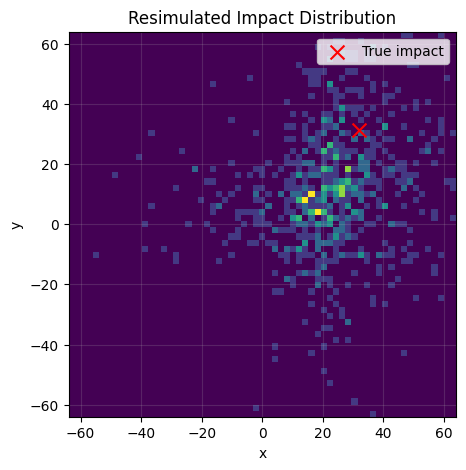

In [20]:
# Plot a heatmap of X_resimulation[0, impact_indices, :2]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist2d(X_resimulation_impact_positions[show_index][:, 0], X_resimulation_impact_positions[show_index][:, 1], bins=np.linspace(-64, 64, 64), cmap='viridis');
ax.scatter(X_val_impact_position[0], X_val_impact_position[1], color='red', s=100, marker='x', label='True impact')
ax.grid(axis='both', alpha=0.2);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_title('Resimulated Impact Distribution');
ax.legend();

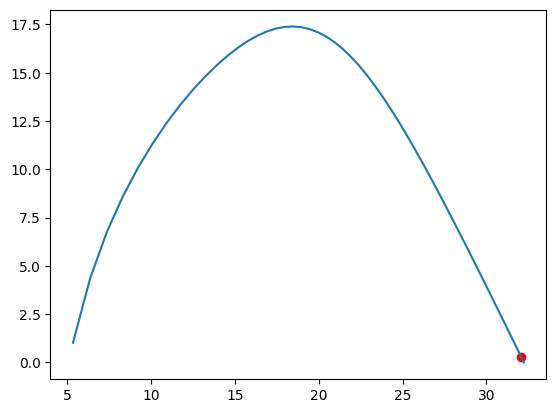

In [21]:
plt.plot(X_val[show_index, :, 0], X_val[show_index, :, -1], label='True trajectory');
plt.scatter(X_val_impact_position[0], X_val_impact_position[-1], color='red', label='Impact');

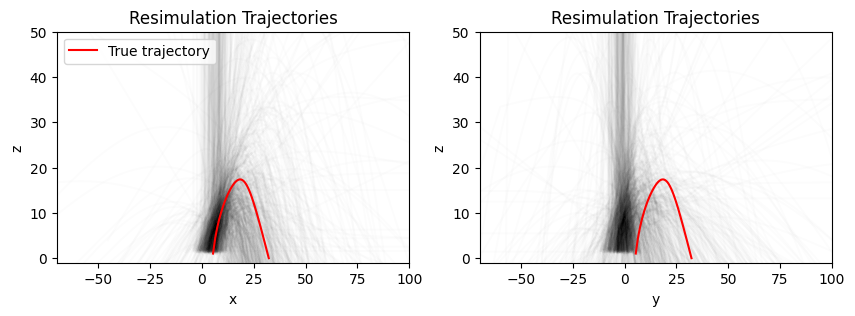

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

n_trajectories = 1000
max_time = 1000


for i, (ax, ax_name) in enumerate(zip(axes, ['x', 'y'])):
    ax.plot(X_resimulation[show_index, :n_trajectories, :max_time, i].T, X_resimulation[show_index, :n_trajectories, :max_time, -1].T, alpha=0.01, color='black');
    ax.plot(X_val[show_index, :, 0], X_val[show_index, :, 2], label='True trajectory', color='red');
    ax.set_xlim(-70, 100)
    ax.set_ylim(-1, 50)
    ax.set_xlabel(ax_name);
    ax.set_ylabel('z');
    ax.set_title('Resimulation Trajectories');

axes[0].legend();